In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np

from random import randint
from db.session import get_last_data_by_symbol
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
recordsAll = get_last_data_by_symbol(symbol="PAWS")
#recordsAll = get_last_data_by_symbol(symbol="xem")

# Convert result to Pandas DataFrame
df = pd.DataFrame(recordsAll.fetchall(), columns=list(recordsAll.keys()))

# Set the timestamp column as the index
df.set_index('created_at', inplace=True)

**Prepare Data**

In [75]:
df["price_change"] = df["lastPrice"].pct_change()
df["volume_change"] = df["volume24h"].pct_change()
df["bid_ask_ratio"] = (df["bid1Size"] / (df["ask1Size"] + 1e-9))

df["mean_price_2"] = df["price_change"].rolling(window=2).mean()
df["mean_price_4"] = df["price_change"].rolling(window=4).mean()
#df["mean_price_8"] = df["price_change"].rolling(window=8).mean()

df["mean_volume_2"] = df["volume_change"].rolling(window=2).mean()
df["mean_volume_4"] = df["volume_change"].rolling(window=4).mean()
#df["mean_volume_8"] = df["volume_change"].rolling(window=8).mean()
df["mean_volume_8_16"] = df["volume_change"].shift(8).rolling(window=8).mean()
df["mean_volume_16_32"] = df["volume_change"].shift(16).rolling(window=16).mean()
df["mean_volume_32_64"] = df["volume_change"].shift(32).rolling(window=32).mean()

df["mean_bid_ask_ratio_4"] = df["bid_ask_ratio"].rolling(window=4).mean()
df["mean_bid_ask_ratio_8_16"] = df["bid_ask_ratio"].shift(8).rolling(window=8).mean()
df["mean_bid_ask_ratio_16_32"] = df["bid_ask_ratio"].shift(16).rolling(window=16).mean()
df["mean_bid_ask_ratio_32_64"] = df["bid_ask_ratio"].shift(32).rolling(window=32).mean()

# Target
lp_shift_3 = df["lastPrice"].shift(-3).rolling(window=3).mean()
lp_shift_3_6 = df["lastPrice"].shift(-6).rolling(window=3).mean()
lp_shift_2 = df["lastPrice"].shift(-2).rolling(window=2).mean()

df["future_return_pcnt_3"] = (lp_shift_3 - df["lastPrice"]) / df["lastPrice"] * 100
df["future_return_pcnt_6"] = (lp_shift_3_6 - df["lastPrice"]) / df["lastPrice"] * 100
df["future_return_pcnt_2"] = (lp_shift_2 - df["lastPrice"]) / df["lastPrice"] * 100

df["final_target_7_after_6_period"] = (df["future_return_pcnt_6"] >= 7).astype(int)
df["final_target_5_after_3_period"] = (df["future_return_pcnt_3"] >= 5).astype(int)
df["final_target_10_after_2_period"] = (df["future_return_pcnt_2"] >= 10).astype(int)


# Final target combining both conditions*
df["final_target"] = df["final_target_7_after_6_period"]

skewness = df["lastPrice"].skew()
kurtosis = df["lastPrice"].kurtosis()
min_price = df["lastPrice"].min()
max_price = df["lastPrice"].max()
price_difference = max_price - min_price
percentage_difference_from_min = (price_difference / min_price) * 100
mode_price = df['lastPrice'].mode().iloc[0]

print(f"Skewness of lastPrice: {skewness}")
print(f"Kurtosis of lastPrice: {kurtosis}")
print(f"Minimum of lastPrice: {min_price}")
print(f"Maximum of lastPrice: {max_price}")
print(f"Mode of lastPrice: {mode_price}")
print(f"Percentage Difference from Minimum: {percentage_difference_from_min}%")

# Drop rows with NaN values
df.dropna(inplace=True)

Skewness of lastPrice: 0.09914768778424907
Kurtosis of lastPrice: -1.8486494654441858
Minimum of lastPrice: 0.005267
Maximum of lastPrice: 0.02596
Mode of lastPrice: 0.02
Percentage Difference from Minimum: 392.8801974558572%


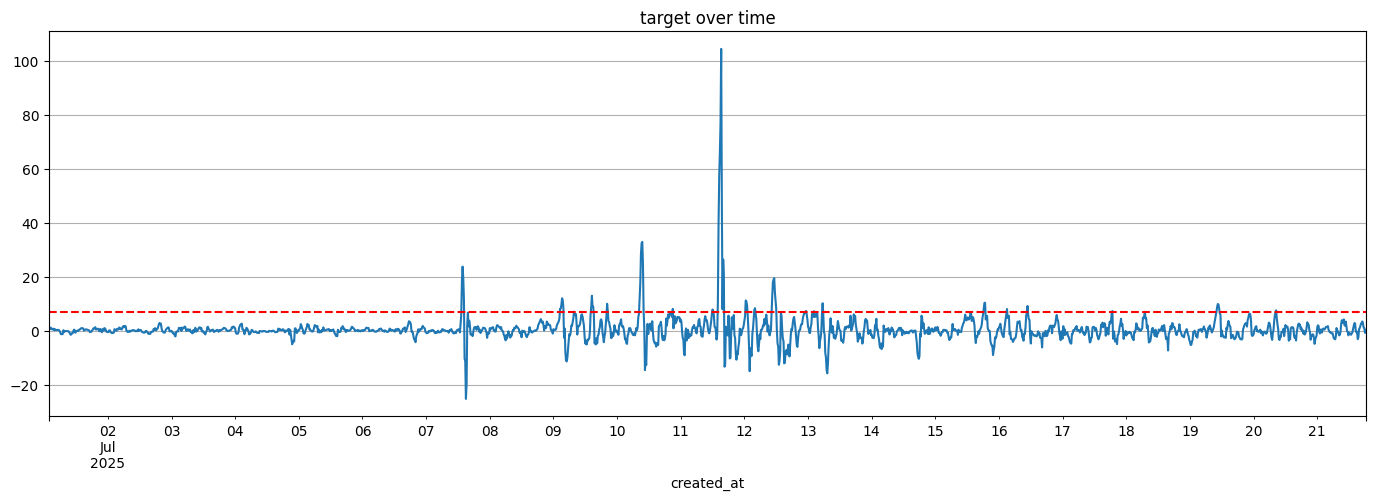

In [78]:
#df["future_return_pcnt_2"].plot(figsize=(17, 5), title="target over time")
df["future_return_pcnt_6"].plot(figsize=(17, 5), title="target over time")


plt.grid(True)
# a line at y=7
plt.axhline(y=7, color='r', linestyle='--', label='Threshold 7%')
plt.show()

In [79]:

# Define the columns for scalling
columns_to_scale = ["price_change", "volume_change", "bid_ask_ratio", 
                    "mean_price_2", "mean_price_4","mean_volume_2", "mean_volume_4", 
                    "mean_volume_8_16", "mean_bid_ask_ratio_4", "mean_bid_ask_ratio_8_16",
                    "mean_volume_16_32", "mean_volume_32_64",
                    "mean_bid_ask_ratio_16_32", "mean_bid_ask_ratio_32_64"]

# 1. Select column
df_to_scale = df[columns_to_scale]

# 2. Create and learn the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df_to_scale)

# 3. Return to DataFrame
scaled_df_part = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)
final_scaled_df = pd.concat([scaled_df_part, df["final_target"]], axis=1)


In [80]:
# Prepare tensor data use dataloaders
X = final_scaled_df[columns_to_scale].values
y = final_scaled_df["final_target"].values
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

total = len(y)
target_count = int(y.sum().item())

print(f"X shape: {X.shape}, y shape: {y.shape}, total samples: {total}, target count: {target_count}")

# Преобразуем данные в TensorDataset
dataset = TensorDataset(X, y)
# Разделяем данные на обучающую и тестовую выборки
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=False)

# Создаем DataLoader для обучающей и тестовой выборок
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



X shape: torch.Size([1988, 14]), y shape: torch.Size([1988, 1]), total samples: 1988, target count: 64


In [26]:
# Анализируем ваши данные
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество образцов: {X.shape[0]}")
print(f"Соотношение классов: {y.mean():.3f}")

# Правило: параметров должно быть меньше образцов
input_dim = X.shape[1]
samples = X.shape[0]
print(f"Максимальное количество параметров: {samples // 10}")

Количество признаков: 14
Количество образцов: 1986
Соотношение классов: 0.007
Максимальное количество параметров: 198


In [9]:
def suggest_hidden_size(input_dim, output_dim, samples):
    """Рекомендации для размера скрытого слоя"""
    
    # Правило 1: 2/3 от входа + выход
    rule1 = int(2/3 * input_dim + output_dim)
    
    # Правило 2: Меньше чем вход
    rule2 = int(input_dim * 0.5)
    
    # Правило 3: Корень из произведения
    rule3 = int((input_dim * output_dim) ** 0.5)
    
    # Правило 4: Степень двойки
    rule4 = 2 ** int(np.log2(input_dim))
    
    print(f"Рекомендации для скрытого слоя:")
    print(f"Правило 2/3+выход: {rule1}")
    print(f"Правило 50% входа: {rule2}")
    print(f"Правило корня: {rule3}")
    print(f"Правило степени 2: {rule4}")
    
    return [rule1, rule2, rule3, rule4]

# Для ваших данных
suggestions = suggest_hidden_size(X.shape[1], 1, X.shape[0])
print(X.shape[1], X.shape[0])

Рекомендации для скрытого слоя:
Правило 2/3+выход: 10
Правило 50% входа: 7
Правило корня: 3
Правило степени 2: 8
14 1985


**Model**

In [81]:
class NetCatcher(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x) # [-1, 1] - это НЕ вероятности!
        x = self.layer2(x)
        x = torch.sigmoid(x)  # Добавляем сигмоиду для получения вероятностей [0, 1]
        return x

In [ ]:
class NetCatcherDropout(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim, dropout=0.2):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.dropout = nn.Dropout(dropout)
        self.layer2 = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.tanh(x)
        x = self.dropout(x)  # Регуляризация
        x = self.layer2(x)
        x = torch.sigmoid(x)
        return x

**Initialization**

In [82]:
# Recreate model with init
model = NetCatcher(input_dim=X.shape[1], num_hidden=7, output_dim=1)
#model = NetCatcherImproved(input_dim=X.shape[1], num_hidden=8, output_dim=1)

# Инициализируем веса
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Проверяем выходы
model.eval()
with torch.no_grad():
    test_outputs = model(X[:10])
    print(f"After init - outputs range: [{test_outputs.min():.3f}, {test_outputs.max():.3f}]")

# Теперь можно обучать
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


After init - outputs range: [0.508, 0.523]
NetCatcher(
  (layer1): Linear(in_features=14, out_features=7, bias=True)
  (layer2): Linear(in_features=7, out_features=1, bias=True)
)


**Training**

In [83]:
num_epochs = 400
for epoch in range(num_epochs):
    model.train() # Устанавливаем модель в режим обучения
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad() # Обнуляем градиенты

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Шаг оптимизатора

        running_loss += loss.item() * inputs.size(0)

        # Для расчета точности
        predicted = (outputs >= 0.5).float() # Преобразуем вероятности в 0 или 1
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset) # type: ignore
    epoch_accuracy = correct_predictions / total_predictions * 100

    print(f"Эпоха {epoch+1}/{num_epochs}, Потери на обучении: {epoch_loss:.4f}, Точность на обучении: {epoch_accuracy:.2f}%")

Эпоха 1/400, Потери на обучении: 0.4903, Точность на обучении: 90.75%
Эпоха 2/400, Потери на обучении: 0.2536, Точность на обучении: 96.42%
Эпоха 3/400, Потери на обучении: 0.1925, Точность на обучении: 96.42%
Эпоха 4/400, Потери на обучении: 0.1723, Точность на обучении: 96.42%
Эпоха 5/400, Потери на обучении: 0.1638, Точность на обучении: 96.42%
Эпоха 6/400, Потери на обучении: 0.1597, Точность на обучении: 96.42%
Эпоха 7/400, Потери на обучении: 0.1575, Точность на обучении: 96.42%
Эпоха 8/400, Потери на обучении: 0.1564, Точность на обучении: 96.42%
Эпоха 9/400, Потери на обучении: 0.1557, Точность на обучении: 96.42%
Эпоха 10/400, Потери на обучении: 0.1553, Точность на обучении: 96.42%
Эпоха 11/400, Потери на обучении: 0.1551, Точность на обучении: 96.42%
Эпоха 12/400, Потери на обучении: 0.1549, Точность на обучении: 96.42%
Эпоха 13/400, Потери на обучении: 0.1548, Точность на обучении: 96.42%
Эпоха 14/400, Потери на обучении: 0.1547, Точность на обучении: 96.42%
Эпоха 15/400, П

In [30]:
print(list(model.parameters()))


[Parameter containing:
tensor([[-1.3008, -0.4858, -0.0091, -0.5989, -1.6962,  0.2703, -0.7660, -1.2956,
          0.2569,  0.2535,  0.1417, -0.3022,  0.2493,  0.0135],
        [-0.6647,  0.0466,  0.7665,  0.1655,  0.7581,  0.2499, -0.2011,  0.6761,
          0.0155,  0.0792, -0.0066,  0.0904,  0.5668,  0.4349],
        [-0.0856,  0.1429, -0.4690,  0.1726, -0.4735, -0.0667, -0.0464, -0.3425,
         -0.2518, -0.4058, -0.2306,  0.0789, -0.2580, -0.1645],
        [-0.0255, -0.0599, -0.4488,  0.0707, -0.1639, -0.1452, -0.2566, -0.5863,
         -0.2389, -0.6193,  0.1117,  0.3985, -0.4199,  0.1126],
        [-0.4809,  0.1459, -0.2863, -0.5207, -0.0441, -0.1026, -0.2151, -0.3151,
         -0.3220,  0.1177,  0.2148, -0.6078, -0.0262, -0.0891],
        [-0.3724, -0.4852,  0.0745,  0.4025, -0.2216,  0.1288, -0.2221, -0.7412,
         -0.5839, -0.0156, -0.0406,  0.2390, -0.3028, -0.1042],
        [-0.2498,  0.4545,  0.5107, -0.0438,  0.4337, -0.0442,  0.1120,  0.1930,
         -0.0038,  0.6473,

**Evaluate 0**

In [84]:
# --- Расчет матрицы ошибок и других метрик на тестовых данных ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime

model.eval() # Переводим модель в режим оценки
all_labels = []
all_predictions = []

with torch.no_grad(): # Отключаем расчет градиентов
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_classes = (outputs >= 0.5).float() # Преобразуем вероятности в бинарные классы (0 или 1)

        all_labels.extend(labels.cpu().numpy()) # Переводим в NumPy и добавляем в список
        all_predictions.extend(predicted_classes.cpu().numpy())

# Преобразуем списки в массивы NumPy для sklearn
all_labels = np.array(all_labels).flatten()
all_predictions = np.array(all_predictions).flatten()

# 1. Матрица ошибок
cm = confusion_matrix(all_labels, all_predictions)
print("\nМатрица Ошибок:")
print(cm)

# Чтобы понять, что означают строки/столбцы:
# [[TN, FP],
#  [FN, TP]]

# 2. Извлечение компонентов матрицы ошибок (опционально)
TN, FP, FN, TP = cm.ravel() # Удобный способ извлечь значения

print(f"\nИстинные Положительные (TP): {TP}")
print(f"Ложноположительные (FP): {FP}")
print(f"Ложноотрицательные (FN): {FN}")
print(f"Истинные Отрицательные (TN): {TN}")

# 3. Расчет других метрик с помощью sklearn (полезно для полного отчета)
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nМетрики производительности:")
print(f"Точность (Accuracy): {accuracy:.4f}")
print(f"Точность (Precision): {precision:.4f}")
print(f"Полнота (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Матрица Ошибок:
[[391   0]
 [  7   0]]

Истинные Положительные (TP): 0
Ложноположительные (FP): 0
Ложноотрицательные (FN): 7
Истинные Отрицательные (TN): 391

Метрики производительности:
Точность (Accuracy): 0.9824
Точность (Precision): 0.0000
Полнота (Recall): 0.0000
F1-Score: 0.0000


/Users/dmytrohalkin/workspace/Neiro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


**Evaluate**

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime

model.eval()
with torch.no_grad():
    # Получаем предсказания
    raw_outputs = model(X)
    # Несмотря на то, что в вашей модели последним слоем стоит tanh, для задачи бинарной классификации с BCEWithLogitsLoss обычно выход модели должен быть "сырым" (logits), а не вероятностью. 
    # BCEWithLogitsLoss сам внутри применяет сигмоиду, поэтому для получения вероятности для метрик и анализа мы явно применяем torch.sigmoid.
    # Если бы вы использовали nn.Sigmoid() как последний слой, то сигмоиду отдельно применять не нужно было бы.
    # Но у вас tanh, а не sigmoid, поэтому torch.sigmoid(outputs) даст корректную вероятность для бинарной классификации.
    
    # 2. Преобразуем в вероятности
    probabilities = raw_outputs #torch.sigmoid(raw_outputs)
    print(f"Probabilities range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
    
    # 3. Получаем бинарные предсказания
    predictions = (probabilities > 0.5).float()
    
    # Преобразуем в numpy для sklearn метрик
    y_true = y.cpu().numpy().flatten() if isinstance(y, torch.Tensor) else np.asarray(y).flatten()
    y_pred = predictions.cpu().numpy().flatten()
    y_proba = probabilities.cpu().numpy().flatten()
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # ROC AUC только если есть оба класса
    if len(np.unique(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, y_proba)
    else:
        roc_auc = "N/A (only one class present)"
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    
    print(f"Класс 0: {np.sum(y_true == 0)} ({np.mean(y_true == 0)*100:.1f}%)")
    print(f"Класс 1: {np.sum(y_true == 1)} ({np.mean(y_true == 1)*100:.1f}%)")
    
    print(f"Предсказано 0: {np.sum(y_pred == 0)} ({np.mean(y_pred == 0)*100:.1f}%)")
    print(f"Предсказано 1: {np.sum(y_pred == 1)} ({np.mean(y_pred == 1)*100:.1f}%)")
    print(f"\nМатрица ошибок:")
    print(cm)
    print(f"\nДетальный отчет:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"\nДата: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Probabilities range: [0.019, 0.878]
Accuracy: 0.9693
Precision: 0.8000
Recall: 0.0625
F1-Score: 0.1159
ROC-AUC: 0.6651344854469854
Класс 0: 1924 (96.8%)
Класс 1: 64 (3.2%)
Предсказано 0: 1983 (99.7%)
Предсказано 1: 5 (0.3%)

Матрица ошибок:
[[1923    1]
 [  60    4]]

Детальный отчет:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1924
         1.0       0.80      0.06      0.12        64

    accuracy                           0.97      1988
   macro avg       0.88      0.53      0.55      1988
weighted avg       0.96      0.97      0.96      1988


Дата: 2025-07-21 20:02:54


[[TN, FP],
 [FN, TP]]
 
TN (True Negative): 
Истинно Отрицательные - Модель правильно предсказала класс 0 (цена не повысится), когда истинный класс тоже был 0.
FP (False Positive): 
Ложноположительные - Модель ошибочно предсказала класс 1 (цена повысится), когда истинный класс был 0.
FN (False Negative): 
Ложноотрицательные - Модель ошибочно предсказала класс 0 (цена не повысится), когда истинный класс был 1. 
TP (True Positive): 
Истинно Положительные - Модель правильно предсказала класс 1 (цена повысится), когда истинный класс тоже был 1.

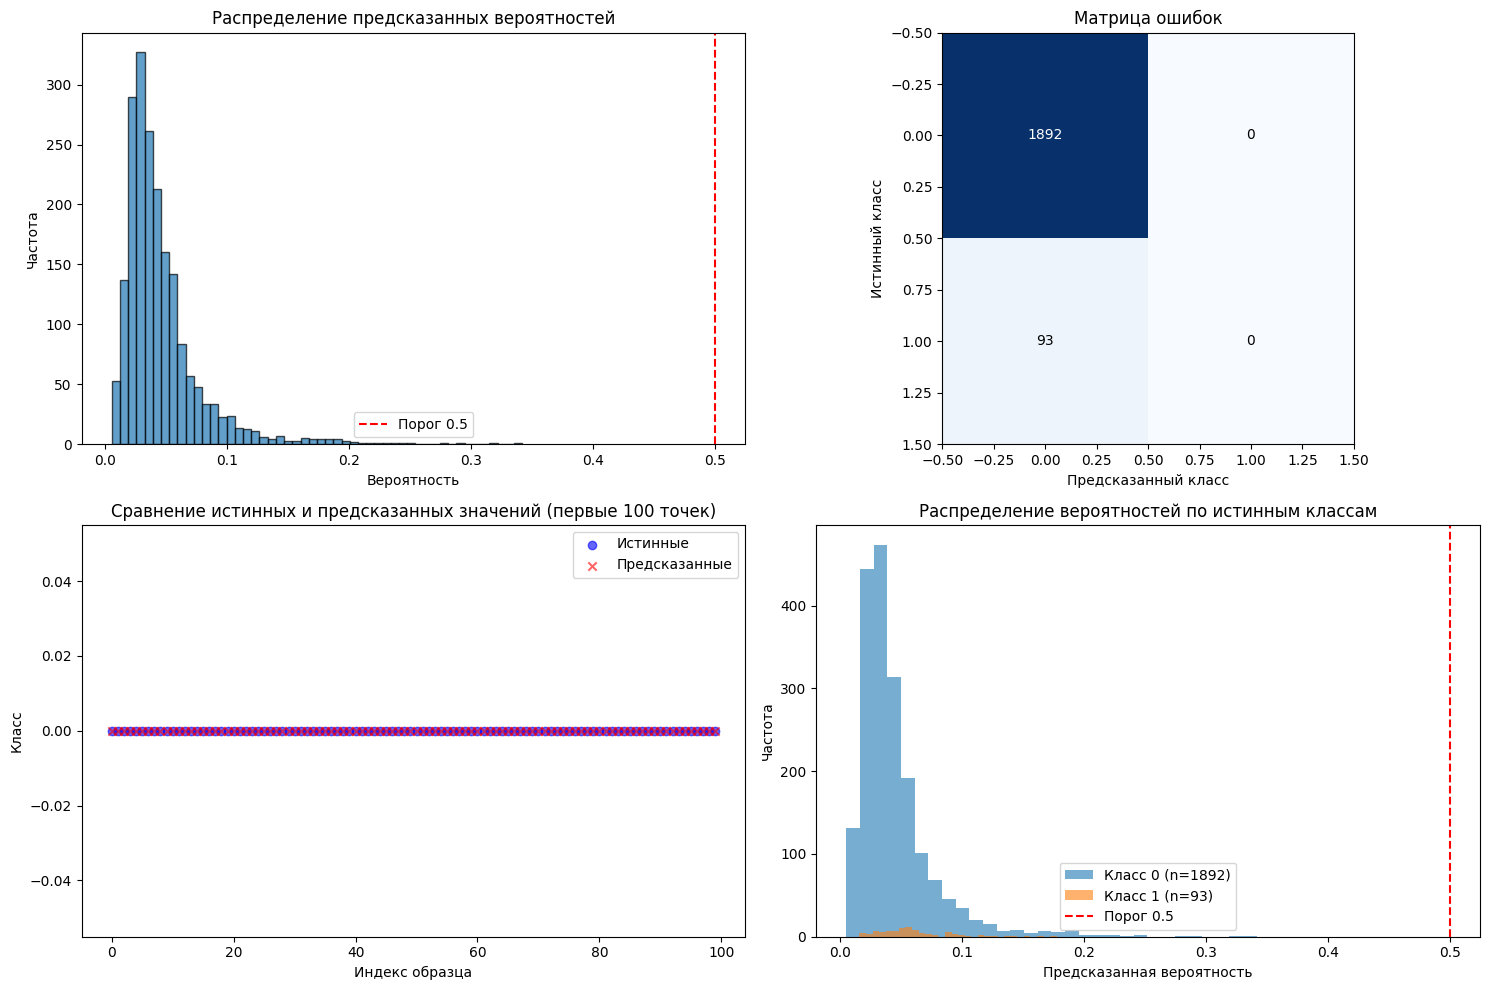

In [16]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение вероятностей
axes[0, 0].hist(y_proba, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Распределение предсказанных вероятностей')
axes[0, 0].set_xlabel('Вероятность')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
axes[0, 0].legend()

# 2. Матрица ошибок
im = axes[0, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 1].set_title('Матрица ошибок')
axes[0, 1].set_xlabel('Предсказанный класс')
axes[0, 1].set_ylabel('Истинный класс')
# Добавляем числа в ячейки
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0, 1].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > cm.max() / 2. else "black")

# 3. Сравнение истинных и предсказанных значений (первые 100 точек)
sample_size = min(100, len(y_true))
x_axis = range(sample_size)
axes[1, 0].scatter(x_axis, y_true[:sample_size], alpha=0.6, label='Истинные', color='blue')
axes[1, 0].scatter(x_axis, y_pred[:sample_size], alpha=0.6, label='Предсказанные', color='red', marker='x')
axes[1, 0].set_title(f'Сравнение истинных и предсказанных значений (первые {sample_size} точек)')
axes[1, 0].set_xlabel('Индекс образца')
axes[1, 0].set_ylabel('Класс')
axes[1, 0].legend()

# 4. Распределение вероятностей по классам
for class_val in [0, 1]:
    mask = y_true == class_val
    if np.sum(mask) > 0:
        axes[1, 1].hist(y_proba[mask], bins=30, alpha=0.6, 
                       label=f'Класс {class_val} (n={np.sum(mask)})')
axes[1, 1].set_title('Распределение вероятностей по истинным классам')
axes[1, 1].set_xlabel('Предсказанная вероятность')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===


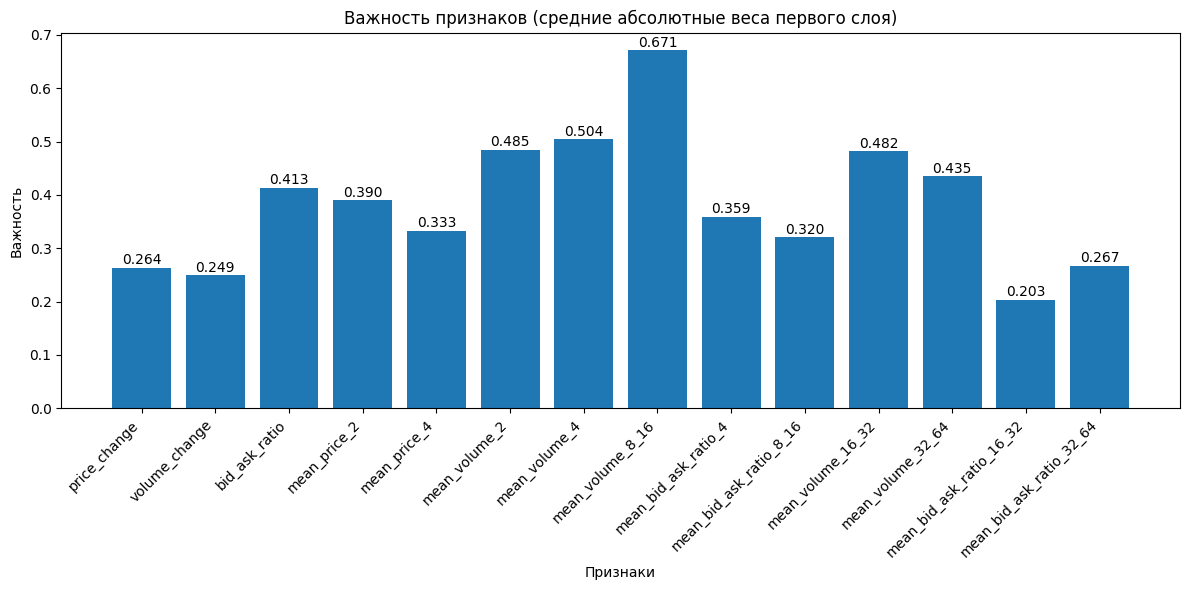


Топ-5 самых важных признаков:
mean_volume_8_16: 0.6709
mean_volume_4: 0.5040
mean_volume_2: 0.4848
mean_volume_16_32: 0.4818
mean_volume_32_64: 0.4350

=== ДОПОЛНИТЕЛЬНАЯ ДИАГНОСТИКА ===
Средняя предсказанная вероятность: 0.0460
Стандартное отклонение вероятностей: 0.0335
Минимальная вероятность: 0.0054
Максимальная вероятность: 0.3417
Уникальных значений вероятностей: 785 из 1985

Ошибки классификации:
Ложноположительные (FP): 0
Ложноотрицательные (FN): 93
Средняя вероятность для FN: 0.0630


In [17]:
# Анализ важности признаков (веса первого слоя)
print("\n=== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ===")
first_layer_weights = model.layer1.weight.data.numpy()
feature_importance = np.abs(first_layer_weights).mean(axis=0)

plt.figure(figsize=(12, 6))
feature_names = columns_to_scale
bars = plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Важность признаков (средние абсолютные веса первого слоя)')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{feature_importance[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Выводим топ-5 самых важных признаков
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nТоп-5 самых важных признаков:")
for i, row in importance_df.head().iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Дополнительная диагностика
print(f"\n=== ДОПОЛНИТЕЛЬНАЯ ДИАГНОСТИКА ===")
print(f"Средняя предсказанная вероятность: {y_proba.mean():.4f}")
print(f"Стандартное отклонение вероятностей: {y_proba.std():.4f}")
print(f"Минимальная вероятность: {y_proba.min():.4f}")
print(f"Максимальная вероятность: {y_proba.max():.4f}")

# Проверяем, есть ли признаки переобучения
unique_probs = len(np.unique(np.round(y_proba, 4)))
total_samples = len(y_proba)
print(f"Уникальных значений вероятностей: {unique_probs} из {total_samples}")
if unique_probs < total_samples * 0.1:
    print("⚠️  Предупреждение: Мало уникальных вероятностей - возможно переобучение!")

# Анализ ошибок
false_positives = np.sum((y_pred == 1) & (y_true == 0))
false_negatives = np.sum((y_pred == 0) & (y_true == 1))
print(f"\nОшибки классификации:")
print(f"Ложноположительные (FP): {false_positives}")
print(f"Ложноотрицательные (FN): {false_negatives}")

if false_positives > 0:
    fp_probs = y_proba[(y_pred == 1) & (y_true == 0)]
    print(f"Средняя вероятность для FP: {fp_probs.mean():.4f}")

if false_negatives > 0:
    fn_probs = y_proba[(y_pred == 0) & (y_true == 1)]
    print(f"Средняя вероятность для FN: {fn_probs.mean():.4f}")

In [38]:
# save the model
torch.save(model.state_dict(), "save_models/linear_net_catcher.pth")

In [ ]:
 # getting the model from file
model = NetCatcher(input_dim=X.shape[1], num_hidden=16, output_dim=1)
model.load_state_dict(torch.load("save_models/linear_net_catcher.pth"))

**Test**

In [ ]:
print(list(model.parameters()))